In [1]:
import sys
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
from scipy import stats
import statistics
from scipy.stats import rankdata
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn import metrics, preprocessing
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
np.random.seed(1)
plt.style.use('seaborn-whitegrid')

In [2]:
cols = ['status', 'duration', 'credit_hist', 'purpose', 'credit_amt', 'savings', 'employment', 'install_rate', 'personal_status', 'debtors', 'residence', 'property', 'age', 'install_plans', 'housing', 'num_credits', 'job', 'num_liable', 'telephone', 'foreign_worker', 'credit']
df = pd.read_table('german.data', names=cols, sep=" ", index_col=False)

**Pre-processing** (categorical to numerical)

In [3]:
 def preprocess(df):
    df['status'] = df['status'].map({'A11': 0, 'A12': 1, 'A13': 2, 'A14': 3}).astype(int)
    
    df.loc[(df['duration'] <= 12), 'duration'] = 0
    df.loc[(df['duration'] > 12) & (df['duration'] <= 24), 'duration'] = 1
    df.loc[(df['duration'] > 24) & (df['duration'] <= 36), 'duration'] = 2
    df.loc[(df['duration'] > 36), 'duration'] = 3    
    
    df['credit_hist'] = df['credit_hist'].map({'A34': 0, 'A33': 1, 'A32': 2, 'A31': 3, 'A30': 4}).astype(int)    
    df = pd.concat([df, pd.get_dummies(df['purpose'], prefix='purpose')],axis=1)

    df.loc[(df['credit_amt'] <= 2000), 'credit_amt'] = 0
    df.loc[(df['credit_amt'] > 2000) & (df['credit_amt'] <= 5000), 'credit_amt'] = 1
    df.loc[(df['credit_amt'] > 5000), 'credit_amt'] = 2    
    
    df['savings'] = df['savings'].map({'A61': 0, 'A62': 1, 'A63': 2, 'A64': 3, 'A65': 4}).astype(int)
    df['employment'] = df['employment'].map({'A71': 0, 'A72': 1, 'A73': 2, 'A74': 3, 'A75': 4}).astype(int)    
    df['gender'] = df['personal_status'].map({'A91': 1, 'A92': 0, 'A93': 1, 'A94': 1, 'A95': 0}).astype(int)
    df['debtors'] = df['debtors'].map({'A101': 0, 'A102': 1, 'A103': 2}).astype(int)
    df['property'] = df['property'].map({'A121': 3, 'A122': 2, 'A123': 1, 'A124': 0}).astype(int)        
    df['age'] = df['age'].apply(lambda x : 1 if x >= 45 else 0) # 1 if old, 0 if young
    df['install_plans'] = df['install_plans'].map({'A141': 1, 'A142': 1, 'A143': 0}).astype(int)
    df = pd.concat([df, pd.get_dummies(df['housing'], prefix='housing')],axis=1)
    df['job'] = df['job'].map({'A171': 0, 'A172': 1, 'A173': 2, 'A174': 3}).astype(int)    
    df['telephone'] = df['telephone'].map({'A191': 0, 'A192': 1}).astype(int)
    df['foreign_worker'] = df['foreign_worker'].map({'A201': 1, 'A202': 0}).astype(int)
    
    df['credit'] = df['credit'].replace(2, 0) #1 = Good, 2= Bad credit risk

#     process age
#     df.loc[(df['age'] >= 15) & (df['age'] <= 24) , 'age'] = 0
#     df.loc[(df['age'] >= 25) & (df['age'] <= 34) , 'age'] = 1
#     df.loc[(df['age'] >= 35) & (df['age'] <= 44) , 'age'] = 2
#     df.loc[(df['age'] >= 45) & (df['age'] <= 54) , 'age'] = 3
#     df.loc[(df['age'] >= 55) & (df['age'] <= 64) , 'age'] = 4
#     df.loc[(df['age'] >= 65) , 'age'] = 5

    return df

df = preprocess(df)

# df = df.drop(columns=['purpose', 'personal_status', 'housing', 'credit'])
df = df.drop(columns=['purpose', 'personal_status', 'housing'])

y = df['credit']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

# X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=1)
# X_train = X_train.reset_index(drop=True)
# X_test = X_test.reset_index(drop=True)
# X_train = X_train.drop(columns=['credit'])
# X_test = X_test.drop(columns=['credit'])
# y_train = y_train.reset_index(drop=True)
# y_test = y_test.reset_index(drop=True)

**Protected, privileged**

In [4]:
# protected: 'gender'=0
# privileged: 'gender'=1

# protected: 'age'=0
# privileged: 'age'=1

In [5]:
epsilon = 0.07 #fraction of poisoned points
vicinity_distance = 4.32
# chosen as less than one standard deviation away
# distances = []
# for i in range(len(df)):
#     xi = df.iloc[i]
#     for j in range(i):
#         distances.append(np.linalg.norm(df.iloc[j] - xi))
# vicinity_distance = statistics.mean(distances) - statistics.pstdev(distances)

df_privileged = df_train[df_train['age'] == 1]
df_protected = df_train[df_train['age'] == 0]

dc_neg = len(df_train[df_train['credit'] == 0])
dc_pos = len(df_train[df_train['credit'] == 1])

In [6]:
# to decide on the vicinity_distance
plotDistances = False
if plotDistances:
    distances = []
    for i in range(len(df)):
        xi = df.iloc[i]
        for j in range(i):
            distances.append(np.linalg.norm(df.iloc[j] - xi))

    import matplotlib.pyplot as plt

    n, bins, patches = plt.hist(x=distances, bins='auto', color='#0504aa',
                                alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('L2-norm')
    plt.ylabel('Frequency')
    plt.title('L2-norm between two points')
    plt.text(23, 45, r'$\mu=15, b=3$')
    maxfreq = n.max()
    # Set a clean upper y-axis limit.
    plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [7]:
# data poisoning
data_poisoning = True
isRandom = False
def select_xtarget_in_demographic(df, privileged, isRandom):
    if privileged:
        df_temp = df[df['credit'] == 0]
    else:
        df_temp = df[df['credit'] == 1]
        
    if isRandom: # random anchoring attack
        idx = math.ceil(random.uniform(0, len(df_temp)))
    else:    # non-random anchoring attack    
        cx = [0]*len(df_temp)
        for i in range(len(df_temp)):
            xi = df_temp.iloc[i]
            for j in range(len(df_temp)):
                if np.linalg.norm(df_temp.iloc[j] - xi) < vicinity_distance:
                    cx[i] += 1
        idx = cx.index(max(cx))
        
    return df_temp.iloc[idx]


if data_poisoning:
    x_target_da = select_xtarget_in_demographic(df_privileged, True, isRandom) #D_a advantaged group
    x_target_dd = select_xtarget_in_demographic(df_protected, False, isRandom) #D_d disadvantaged group

    for i in range(0, math.ceil(epsilon * dc_neg)):
        x = x_target_da.copy()
        x['credit'] = 1
        df_train = df_train.append(x, ignore_index=True)

    for i in range(0, math.ceil(epsilon * dc_pos)):
        x = x_target_dd.copy()
        x['credit'] = 0
        df_train = df_train.append(x, ignore_index=True)

In [8]:
y_train = df_train['credit']
y_train = y_train.reset_index(drop=True)
y_test = df_test['credit']
y_test = y_test.reset_index(drop=True)

X_train = df_train.drop(columns=['credit'])
X_train = X_train.reset_index(drop=True)
X_test = df_test.drop(columns=['credit'])
X_test = X_test.reset_index(drop=True)

**Parametric Model**

In [9]:
X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = LogisticRegression(random_state=0, max_iter=300)

**Compute fairness metric**

In [10]:
def computeFairness(y_pred, X_test, y_test, metric): 
    fairnessMetric = 0
    protected_idx = X_test[X_test['age']==0].index
    numProtected = len(protected_idx)
    privileged_idx = X_test[X_test['age']==1].index
    numPrivileged = len(privileged_idx)
        
    p_protected = 0
    for i in range(len(protected_idx)):
        p_protected += y_pred[protected_idx[i]][1]
    p_protected /= len(protected_idx)
    
    p_privileged = 0
    for i in range(len(privileged_idx)):
        p_privileged += y_pred[privileged_idx[i]][1]
    p_privileged /= len(privileged_idx)
    
    # statistical parity difference
    statistical_parity = p_protected - p_privileged
    
    # equality of opportunity, or 
    # true positive rate parity
    # P(Y=1 | Y=1, G=0)- P(Y=1 | Y=1, G=1)
    true_positive_protected = 0
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            true_positive_protected += y_pred[protected_idx[i]][1]
    tpr_protected = true_positive_protected/actual_positive_protected
    
    true_positive_privileged = 0
    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            true_positive_privileged += y_pred[privileged_idx[i]][1]
    tpr_privileged = true_positive_privileged/actual_positive_privileged
    
    tpr_parity = tpr_protected - tpr_privileged
    
    # equalized odds or TPR parity + FPR parity
    # false positive rate parity
    
    # predictive parity
    p_o1_y1_s1 = 0
    p_o1_s1 = 0
    for i in range(len(protected_idx)):
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        p_o1_s1 += y_pred[protected_idx[i]][1]
        if (y_test[protected_idx[i]] == 1):
            p_o1_y1_s1 += y_pred[protected_idx[i]][1]
    ppv_protected = p_o1_y1_s1/p_o1_s1
    
    p_o1_y1_s0 = 0
    p_o1_s0 = 0
    for i in range(len(privileged_idx)):
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        p_o1_s0 += y_pred[privileged_idx[i]][1]
        if (y_test[privileged_idx[i]] == 1):
            p_o1_y1_s0 += y_pred[privileged_idx[i]][1]
    ppv_privileged = p_o1_y1_s0/p_o1_s0
    
    predictive_parity = ppv_protected - ppv_privileged
    
    if (metric == 0):
        fairnessMetric = statistical_parity
    elif (metric == 1):
        fairnessMetric = tpr_parity
    elif (metric == 2):
        fairnessMetric = predictive_parity
        
    return fairnessMetric

**Compute Accuracy** 

In [11]:
from sklearn.metrics import accuracy_score

def computeAccuracy(y_true, y_pred):
    accuracy = 0
    for i in range(len(y_true)):
        idx = y_true[i]
        if (y_pred[i][idx] > y_pred[i][1 - idx]):
            accuracy += 1
#         accuracy += y_pred[i][idx]
    accuracy /= len(y_true)
    return accuracy

**Metrics: Initial state**

In [12]:
clf.fit(X_train, y_train)
num_params = len(clf.coef_.transpose()) + 1 #weights and intercept; params: clf.coef_, clf.intercept_
y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0)
tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1)
predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2)
accuracy_0 = computeAccuracy(y_test, y_pred_test)

print(spd_0, tpr_parity_0, predictive_parity_0, accuracy_0)

-0.1746003568206128 -0.14577701431929957 -0.086129706543417 0.715


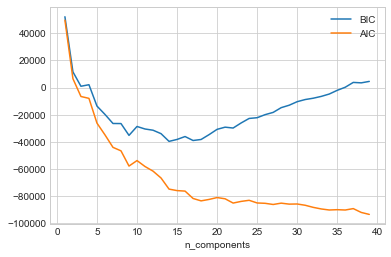

In [13]:
from sklearn import mixture
n_components = np.arange(1, 40)
models = [mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(X_train)
          for n in n_components]

plt.plot(n_components, [m.bic(X_train) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_train) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

In [13]:
from sklearn.mixture import GaussianMixture
numClusters = 14
model = GaussianMixture(n_components=numClusters, covariance_type='full', random_state=0).fit(X_train)
X_train_orig['cluster'] = model.predict(X_train)

In [14]:
# **First-order derivative of loss function at z with respect to model parameters**
def del_L_del_theta_i(num_params, y_true, x, y_pred):
#     del_L_del_theta = np.ones((num_params, 1)) * ((1 - y_true) * y_pred[1] - y_true * y_pred[0])
    del_L_del_theta = np.ones((num_params, 1)) * (- y_true + y_pred[1])
    for j in range(1, num_params):
            del_L_del_theta[j] *=  x[j-1]
    return del_L_del_theta

# **Hessian: Second-order partial derivative of loss function with respect to model parameters**
def hessian_one_point(num_params, x, y_pred):
    H = np.ones((num_params, num_params)) * (y_pred[0] * y_pred[1])
    for i in range(1, num_params):
        for j in range(i + 1):
            if j == 0:
                H[i][j] *= x[i-1]
            else:
                H[i][j] *= x[i-1] * x[j-1] 
    i_lower = np.tril_indices(num_params, -1)
    H.T[i_lower] = H[i_lower]     
    return H

# **First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**
def del_f_del_theta_i(num_params, x, y_pred):
    del_f_del_theta = np.ones((num_params, 1)) * (y_pred[0] * y_pred[1])
    for j in range(1, num_params):
            del_f_del_theta[j] *=  x[j-1]
    return del_f_del_theta

# **Computing $v=\nabla($Statistical parity difference$)$**
# Return v = del(SPD)/del(theta)
def del_spd_del_theta(num_params, X_test_orig, X_test, y_pred):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    numPrivileged = X_test_orig['age'].sum()
    numProtected = len(X_test_orig) - numPrivileged
    for i in range(len(X_test)):
        del_f_i = del_f_del_theta_i(num_params, X_test[i], y_pred[i])
        if X_test_orig.iloc[i]['age'] == 1: #privileged
            del_f_privileged = np.add(del_f_privileged, del_f_i)
        elif X_test_orig.iloc[i]['age'] == 0:
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_privileged /= numPrivileged
    del_f_protected /= numProtected
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

# **Computing $v=\nabla($TPR parity difference$)$**
# Return v = del(TPR_parity)/del(theta)
def del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    actual_positive_privileged = 0
    for i in range(len(privileged_idx)):
        if (y_test[privileged_idx[i]] == 1):
            actual_positive_privileged += 1
#             if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
            del_f_privileged = np.add(del_f_privileged, del_f_i)
    del_f_privileged /= actual_positive_privileged
    
    actual_positive_protected = 0
    for i in range(len(protected_idx)):
        if (y_test[protected_idx[i]] == 1):
            actual_positive_protected += 1
#             if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
            del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
            del_f_protected = np.add(del_f_protected, del_f_i)
    del_f_protected /= actual_positive_protected

    v = np.subtract(del_f_protected, del_f_privileged)
    return v

# **Computing $v=\nabla($Predictive parity difference$)$**
# Return v = del(Predictive_parity)/del(theta)
def del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred, y_test):
    del_f_protected = np.zeros((num_params, 1))
    del_f_privileged = np.zeros((num_params, 1))
    
    protected_idx = X_test_orig[X_test_orig['age']==0].index
    privileged_idx = X_test_orig[X_test_orig['age']==1].index

    u_dash_protected = np.zeros((num_params, 1))
    v_protected = 0
    v_dash_protected = np.zeros((num_params, 1))
    u_protected = 0
    for i in range(len(protected_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[protected_idx[i]], y_pred[protected_idx[i]])
#         if (y_pred[protected_idx[i]][1] > y_pred[protected_idx[i]][0]):
        v_protected += y_pred[protected_idx[i]][1]
        v_dash_protected = np.add(v_dash_protected, del_f_i)
        if (y_test[protected_idx[i]] == 1):
            u_dash_protected = np.add(u_dash_protected, del_f_i)
            u_protected += y_pred[protected_idx[i]][1]
    del_f_protected = (u_dash_protected * v_protected - u_protected * v_dash_protected)/(v_protected * v_protected)
    
    u_dash_privileged = np.zeros((num_params, 1))
    v_privileged = 0
    v_dash_privileged = np.zeros((num_params, 1))
    u_privileged = 0
    for i in range(len(privileged_idx)):
        del_f_i = del_f_del_theta_i(num_params, X_test[privileged_idx[i]], y_pred[privileged_idx[i]])
#         if (y_pred[privileged_idx[i]][1] > y_pred[privileged_idx[i]][0]):
        v_privileged += y_pred[privileged_idx[i]][1]
        v_dash_privileged = np.add(v_dash_privileged, del_f_i)
        if (y_test[privileged_idx[i]] == 1):
            u_dash_privileged = np.add(u_dash_privileged, del_f_i)
            u_privileged += y_pred[privileged_idx[i]][1]
    del_f_privileged = (u_dash_privileged * v_privileged - u_privileged * v_dash_privileged)/(v_privileged * v_privileged)
    
    v = np.subtract(del_f_protected, del_f_privileged)
    return v

# **Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**
# Uniformly sample t points from training data 
def hessian_vector_product(num_params, n, size, v, hessian_all_points):
    if (size > n):
        size = n
    sample = random.sample(range(n), size)
    hinv_v = copy.deepcopy(v)
    for idx in range(size):
        i = sample[idx]
        hessian_i = hessian_all_points[i]
        hinv_v = np.matmul(np.subtract(np.identity(num_params), hessian_i), hinv_v)
        hinv_v = np.add(hinv_v, v)
    return hinv_v

# **First-order influence computation**
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf[0][0].tolist())
    return infs

# **Second-order influence computation for a group of points in subset U**
def second_order_influence(X_train, U, size, del_L_del_theta, hessian_all_points):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_hinv = np.zeros((num_params, 1))
    del_L_del_theta_sum = np.zeros((num_params, 1))
    hessian_U = np.zeros((num_params, num_params))
    for i in range(u):
        idx = U[i]
        hessian_U = np.add(hessian_U, s * hessian_all_points[idx])
        del_L_del_theta_sum = np.add(del_L_del_theta_sum, del_L_del_theta[idx])
    
    hinv_del_L_del_theta= np.matmul(hinv_exact, del_L_del_theta_sum)
    hinv_hessian_U = np.matmul(hinv_exact, hessian_U)
    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * np.matmul(hinv_hessian_U, hinv_del_L_del_theta)
    sum_term = np.add(term1, term2)
    return sum_term

# **Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.insert(i, del_L_del_theta_i(num_params, y_train[i], X_train[i], y_pred_train[i]))

hessian_all_points = []
for i in range(len(X_train)):
    hessian_all_points.insert(i, hessian_one_point(num_params, X_train[i], y_pred_train[i])
                              /len(X_train))

# *Select delta fairness function depending on selected metric*
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(num_params, X_test_orig, X_test, y_pred_test)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(num_params, X_test_orig, X_test, y_pred_test, y_test)

# *H^{-1} computation*
hexact = 1
if hexact == 1: 
    H_exact = np.zeros((num_params, num_params))
    for i in range(len(X_train)):
        H_exact = np.add(H_exact, hessian_all_points[i])
    hinv_exact = np.linalg.pinv(H_exact) 
    hinv_v = np.matmul(hinv_exact, v1)
else: #using Hessian vector product
    size_hvp = int(len(X_train) * .01)
    hinv_v = hessian_vector_product(num_params, len(X_train), size_hvp, v1, hessian_all_points)

# **First-order influence of each training data point**
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

# **Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 
# (by coherent, we mean group of data points that share some properties)
print("Cluster, Ground-truth subset, Add 1st-order inf individual, \
Second-order subset influence, %rowsRemoved, Accuracy")
inf_gt_ = []
del_f_1_ = []
del_f_2_ = []
accuracy_ = []
for cluster in range(numClusters):
    idx = X_train_orig[X_train_orig['cluster'] == cluster].index 
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    inf_gt = 0
    if len(y.unique()) > 1:
        # Ground truth subset influence
        clf.fit(X, y)
        y_pred = clf.predict_proba(X_test)
        if metric == 0:
            inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        elif metric == 1:
            inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1) - tpr_parity_0
        elif metric == 2:
            inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2) - predictive_parity_0
        accuracy = computeAccuracy(y_test, y_pred)

    # First-order subset influence
    del_f_1 = 0            
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]

    # Second-order subset influence
    size_hvp = 1
    params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
    del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]

    inf_gt_.append(inf_gt)
    del_f_1_.append(del_f_1)
    del_f_2_.append(del_f_2)
    accuracy_.append(accuracy)
    print(cluster, inf_gt, del_f_1, del_f_2, len(idx)/len(X_train), accuracy, sep=", ")

Cluster, Ground-truth subset, Add 1st-order inf individual, Second-order subset influence, %rowsRemoved, Accuracy
0, -0.022986711575908814, -0.004524357012580373, -0.008936514943416808, 0.11551925320886815, 0.7
1, 0.01212808994679515, 0.008585067384509378, 0.011430573240209456, 0.046674445740956826, 0.735
2, 0.0369962131980911, 0.01743862205606076, 0.028051844898366617, 0.16219369894982497, 0.71
3, 0.037976136191036125, 0.009353662044391114, 0.017797577887882277, 0.08751458576429405, 0.715
4, -0.02315619502342714, -0.012647896656121965, -0.01405073123643177, 0.08051341890315053, 0.73
5, -0.0005824684007187386, 0.0011529293859435684, 0.0011653620126431939, 0.007001166861143524, 0.715
6, 0.003964797857101576, 0.003992581301026747, 0.004536370836877175, 0.040840140023337225, 0.71
7, 0.04693160368126825, 0.015457172234603552, 0.02633626587972787, 0.15052508751458576, 0.765
8, -0.008839118194777562, -0.0071816914546019755, -0.007475328636588626, 0.015169194865810968, 0.725
9, -0.00966792982

In [17]:
cluster=7
var='age'
X_train_orig[X_train_orig['cluster'] == cluster][var].sum()/len(X_train_orig[X_train_orig['cluster'] == cluster])

0.10077519379844961

In [30]:
X_train_orig[X_train_orig['cluster'] == cluster][["age", "purpose_A42", "status", "credit_hist", "savings", "credit_amt", "employment", "gender"]].groupby("age").describe()

purpose_A42                                    status            ...  \
          count mean  std  min  25%  50%  75%  max  count      mean  ...   
age                                                                  ...   
0         116.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  116.0  1.931034  ...   
1          13.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0   13.0  1.538462  ...   

    employment      gender                                               
           75%  max  count      mean       std  min  25%  50%  75%  max  
age                                                                      
0          2.0  4.0  116.0  0.793103  0.406838  0.0  1.0  1.0  1.0  1.0  
1          4.0  4.0   13.0  0.615385  0.506370  0.0  0.0  1.0  1.0  1.0  

[2 rows x 56 columns]

In [115]:
X_train_orig.columns

Index(['status', 'duration', 'credit_hist', 'credit_amt', 'savings',
       'employment', 'install_rate', 'debtors', 'residence', 'property', 'age',
       'install_plans', 'num_credits', 'job', 'num_liable', 'telephone',
       'foreign_worker', 'purpose_A40', 'purpose_A41', 'purpose_A410',
       'purpose_A42', 'purpose_A43', 'purpose_A44', 'purpose_A45',
       'purpose_A46', 'purpose_A48', 'purpose_A49', 'gender', 'housing_A151',
       'housing_A152', 'housing_A153', 'cluster'],
      dtype='object')

In [269]:
X_train_orig[X_train_orig['cluster'] == 6]['housing_A152'].describe()

count    141.0
mean       1.0
std        0.0
min        1.0
25%        1.0
50%        1.0
75%        1.0
max        1.0
Name: housing_A152, dtype: float64

<AxesSubplot:>

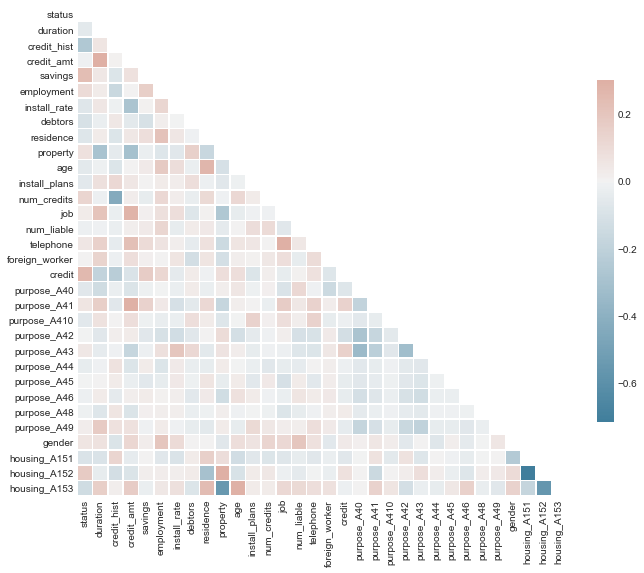

In [165]:
corr = df_train.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 0.7})

In [15]:
idxMaxInfluence = del_f_2_.index(max(del_f_2_))
print(idxMaxInfluence)
idx = X_train_orig[X_train_orig['cluster'] == idxMaxInfluence].index 
poisoned = list(range(800, len(X_train)))
print("Fraction of poisoned points retrieved =", len(list(set(idx) & set(poisoned)))/len(poisoned))

2
Fraction of poisoned points retrieved = 0.0


In [44]:
top = 3
idx_top = sorted(range(len(del_f_2_)), key=lambda i: del_f_2_[i])[-top:]
idx_ = []
for i in range(top - 1, 0, -1):
    elems = X_train_orig[X_train_orig['cluster'] == idx_top[i]].index.values
    for j in range(len(elems)):
        idx_.append(elems[j])

In [45]:
print("Fraction of poisoned points retrieved =", len(list(set(idx_) & set(poisoned)))/len(poisoned))
print("Fraction of points in top-k clusters", len(idx_)/len(X_train))

Fraction of poisoned points retrieved = 0.7017543859649122
Fraction of points in top-k clusters 0.31271878646441076


In [314]:
centers = kmeans.cluster_centers_

In [46]:
centers = model.means_

In [47]:
distances = []
cluster_distances = np.zeros((len(centers), len(centers)))
for i in range(len(centers)):
    for j in range(i):
        cluster_distances[i][j] = np.linalg.norm(centers[i] - centers[j])
        cluster_distances[j][i] = cluster_distances[i][j]
        distances.append(cluster_distances[i][j])

(0.0, 30.0)

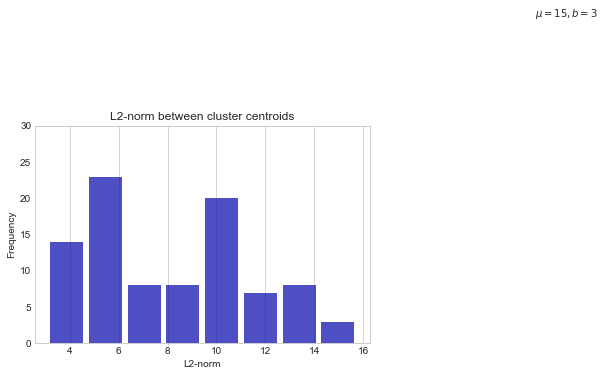

In [48]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=distances, bins='auto', color='#0504ab',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('L2-norm')
plt.ylabel('Frequency')
plt.title('L2-norm between cluster centroids')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [52]:
positive_influence_idx = []
for i in range(len(del_f_2_)):
    if del_f_2_[i] > 0:
        positive_influence_idx.append(i)
        
additive_difference = []
for i in range(len(positive_influence_idx)):
    for j in range(i):
        if cluster_distances[positive_influence_idx[i]][positive_influence_idx[j]] > 8:
            idx_i = X_train_orig[X_train_orig['cluster'] == positive_influence_idx[i]].index 
            idx_j = X_train_orig[X_train_orig['cluster'] == positive_influence_idx[j]].index 
            idx = idx_i.union(idx_j)
            X = np.delete(X_train, idx, 0)
            y = y_train.drop(index=idx, inplace=False)
            
            # ground truth subset influence
            clf.fit(X, y)
            y_pred = clf.predict_proba(X_test)
            inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
            
            # Second-order subset influence
            size_hvp = 1
            params_f_2 = second_order_influence(X_train, idx, size_hvp, del_L_del_theta, hessian_all_points)
            del_f_2 = np.dot(v1.transpose(), params_f_2)[0][0]
            additive_difference.append(abs(del_f_2_[positive_influence_idx[i]] + del_f_2_[positive_influence_idx[j]] - del_f_2))

from statistics import mean
mean(additive_difference)

**Fairness-based Data Repair**

In [54]:
# cross-validation
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5)
# for train_index, test_index in kf.split(X_train):
# #     print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

epsilon_min = -5
epsilon_max = 5
stepsize = 0.1
epsilon = epsilon_min
spd_values = []
epsilon_values = []
while (epsilon < epsilon_max):
    X_train_perturbed = X_train + epsilon
    clf.fit(X_train_perturbed, y_train)
    y_pred_test = clf.predict_proba(X_test)
    spd = computeFairness(y_pred_test, X_test_orig, y_test, 0)
    if spd > spd_0:
        spd_values.append(spd)
        epsilon_values.append(epsilon)
    epsilon += stepsize

In [56]:
ix = spd_values.index(max(spd_values))
print(ix)
print(epsilon_values[ix])
X_train_perturbed = X_train + epsilon_values[ix]
clf.fit(X_train_perturbed, y_train)
y_pred_test = clf.predict_proba(X_test)
print("Perturbed, demographic parity:", computeFairness(y_pred_test, X_test_orig, y_test, 0))
print("Perturbed, accuracy:", computeAccuracy(y_test, y_pred_test))

29
3.2000000000000006
Perturbed, demographic parity: -0.08074676645031853
Perturbed, accuracy: 0.705


In [57]:
X_train_perturbed = X_train + epsilon_values[ix]
print(np.linalg.norm(X_train_perturbed - X_train))
print(np.linalg.norm(X_train))
print(np.linalg.norm(X_train_perturbed))

521.5803677286901
162.9938649152168
546.4550118719746
